#### Decide churn label on the basis of recency

In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.metrics import confusion_matrix, classification_report,roc_auc_score,roc_curve
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('clv_data.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113760 entries, 0 to 113759
Data columns (total 54 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   customer_id                    113760 non-null  object 
 1   customer_unique_id             113760 non-null  object 
 2   customer_zip_code_prefix       113760 non-null  int64  
 3   customer_city                  113760 non-null  object 
 4   customer_state                 113760 non-null  object 
 5   order_id                       113760 non-null  object 
 6   order_status                   113760 non-null  object 
 7   order_purchase_timestamp       113760 non-null  object 
 8   order_approved_at              113760 non-null  object 
 9   order_delivered_carrier_date   113760 non-null  object 
 10  order_delivered_customer_date  113760 non-null  object 
 11  order_estimated_delivery_date  113760 non-null  object 
 12  purchased_approved            

In [4]:
df.isna().sum()

customer_id                           0
customer_unique_id                    0
customer_zip_code_prefix              0
customer_city                         0
customer_state                        0
order_id                              0
order_status                          0
order_purchase_timestamp              0
order_approved_at                     0
order_delivered_carrier_date          0
order_delivered_customer_date         0
order_estimated_delivery_date         0
purchased_approved                    0
approved_carrier                      0
carrier_delivered                     0
delivered_estimated                   0
purchased_delivered                   0
order_item_id                         0
product_id                            0
seller_id                             0
shipping_limit_date                   0
price                                 0
freight_value                         0
product_category_name                 0
product_name_lenght                   0


#### Creating a target variable
##### Assumption of Inactivity


In [5]:
# Assuming churn threshold as 180
churn_threshold_days = 180
df['churn'] = (df['recency'] > churn_threshold_days).astype(int)

In [6]:
df['churn'].value_counts(normalize=True)*100

churn
1    59.690577
0    40.309423
Name: proportion, dtype: float64

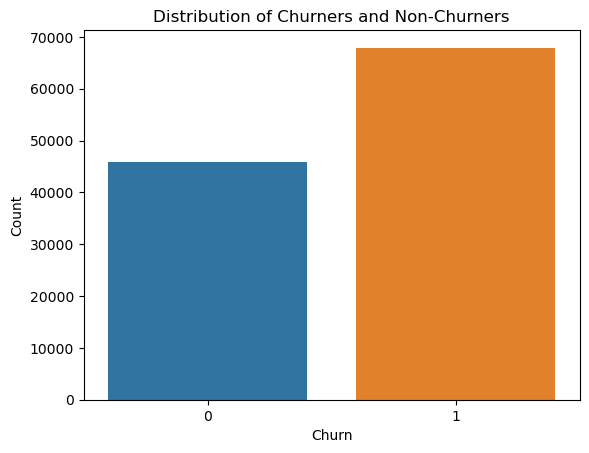

In [7]:
# Visualize the churn segmentation
sns.countplot(x='churn', data=df)
plt.title('Distribution of Churners and Non-Churners')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.show()


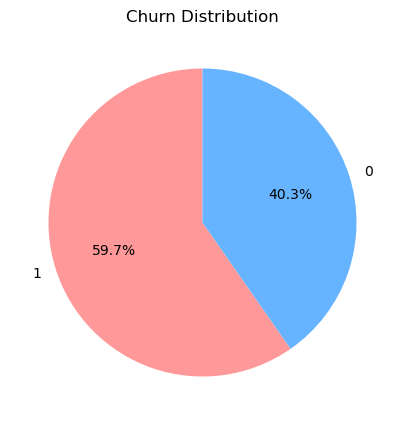

In [8]:
churn_counts = df['churn'].value_counts()

# Plotting the pie chart
plt.figure(figsize=(6, 5))
plt.pie(churn_counts, labels=churn_counts.index, autopct='%1.1f%%', startangle=90, colors=['#ff9999', '#66b3ff'])
plt.title('Churn Distribution')
plt.show()

In [9]:
df['churn'].dtype

dtype('int64')

### Droping unnescessary features

In [10]:
# Drop unnecessary features
unnecessary_features = [
    'customer_id','customer_unique_id','customer_city',
    'order_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at',
    'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date', 'approved_carrier', 'carrier_delivered',

    'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date',
    'product_name_lenght', 'product_description_lenght', 'product_photos_qty','seller_city','seller_state',
    'geolocation_zip_code_prefix',
    'payment_sequential','purchased_approved','delivered_estimated','purchased_delivered',
    'seller_zip_code_prefix', 'payment_value',
    'product_category_name_english','product_category_name','customer_zip_code_prefix','product_length_cm','product_height_cm','product_width_cm',
    'review_id', 'review_comment_title', 'review_comment_message',
    'review_creation_date', 'review_answer_timestamp','late_deliveries','geolocation_lat', 'geolocation_lng','product_weight_g',
]

# Drop unnecessary features from the DataFrame
final = df.drop(unnecessary_features, axis=1)


In [11]:
final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113760 entries, 0 to 113759
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   customer_state        113760 non-null  object 
 1   price                 113760 non-null  float64
 2   freight_value         113760 non-null  float64
 3   payment_type          113760 non-null  object 
 4   payment_installments  113760 non-null  int64  
 5   review_score          112912 non-null  float64
 6   recency               113760 non-null  int64  
 7   frequency             113760 non-null  int64  
 8   monetary_value        113760 non-null  float64
 9   customer_tenure       113760 non-null  int64  
 10  num_orders            113760 non-null  int64  
 11  churn                 113760 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 10.4+ MB


In [12]:
final.head()

,customer_state,price,freight_value,payment_type,payment_installments,review_score,recency,frequency,monetary_value,customer_tenure,num_orders,churn
0,SP,124.99,21.88,credit_card,2,4.0,469,1,146.87,0,1,1
1,PA,112.99,24.90,credit_card,1,1.0,293,2,551.58,0,1,1
2,PA,112.99,24.90,credit_card,1,1.0,293,2,551.58,0,1,1
3,RS,124.99,15.62,credit_card,7,3.0,478,1,140.61,0,1,1
4,RJ,106.99,30.59,credit_card,10,4.0,206,1,137.58,0,1,1


In [13]:
final['review_score'].unique()

array([ 4.,  1.,  3.,  2.,  5., nan])

In [14]:
final['review_score'].value_counts()

review_score
5.0    64981
4.0    21756
1.0    12832
3.0     9512
2.0     3831
Name: count, dtype: int64

In [15]:
final.isna().sum() / len(final) * 100

customer_state          0.000000
price                   0.000000
freight_value           0.000000
payment_type            0.000000
payment_installments    0.000000
review_score            0.745429
recency                 0.000000
frequency               0.000000
monetary_value          0.000000
customer_tenure         0.000000
num_orders              0.000000
churn                   0.000000
dtype: float64

### Treating null values in review_score

In [16]:
mean_score = int(final['review_score'].fillna(0).mean())
mean_score

4

In [17]:
final['review_score'] = df['review_score'].fillna(mean_score).astype(int)

In [18]:
final.head()

,customer_state,price,freight_value,payment_type,payment_installments,review_score,recency,frequency,monetary_value,customer_tenure,num_orders,churn
0,SP,124.99,21.88,credit_card,2,4,469,1,146.87,0,1,1
1,PA,112.99,24.90,credit_card,1,1,293,2,551.58,0,1,1
2,PA,112.99,24.90,credit_card,1,1,293,2,551.58,0,1,1
3,RS,124.99,15.62,credit_card,7,3,478,1,140.61,0,1,1
4,RJ,106.99,30.59,credit_card,10,4,206,1,137.58,0,1,1


In [19]:
final.isna().sum()

customer_state          0
price                   0
freight_value           0
payment_type            0
payment_installments    0
review_score            0
recency                 0
frequency               0
monetary_value          0
customer_tenure         0
num_orders              0
churn                   0
dtype: int64

In [20]:
final.shape

(113760, 12)

In [21]:
final.duplicated().sum()

13865

In [22]:
final = final.drop_duplicates()
final.shape

(99895, 12)

#### Outliers treatment:

In [23]:
print(final.describe())

              price  freight_value  payment_installments  review_score  \
count  99895.000000   99895.000000          99895.000000  99895.000000   
mean     124.443105      20.160313              2.929456      4.127694   
std      188.324396      15.822737              2.736482      1.301725   
min        0.850000       0.000000              0.000000      1.000000   
25%       41.000000      13.200000              1.000000      4.000000   
50%       78.900000      16.390000              2.000000      5.000000   
75%      139.000000      21.315000              4.000000      5.000000   
max     6735.000000     409.680000             24.000000      5.000000   

            recency     frequency  monetary_value  customer_tenure  \
count  99895.000000  99895.000000    99895.000000     99895.000000   
mean     238.997648      1.397778      244.319841         5.787387   
std      152.889394      1.229065      733.118722        37.118114   
min        0.000000      1.000000        9.590000    

In [24]:
# Identify outliers using z-score
from scipy import stats
print(f'Number of rows before filtering outliers : {len(final)}')

filtered_entries = np.array ([True] * len(final))

for col in ['recency', 'frequency', 'monetary_value', 'customer_tenure', 'freight_value','price','num_orders','payment_installments']:
  zscore = abs(stats.zscore(final[col]))
  filtered_entries = (zscore < 3)

final = final[filtered_entries]
print(f'Number of rows after filtering outlier : {len(final)}')


Number of rows before filtering outliers : 99895
Number of rows after filtering outlier : 99559


In [25]:
print(final.describe())

              price  freight_value  payment_installments  review_score  \
count  99559.000000   99559.000000          99559.000000  99559.000000   
mean     123.891504      20.124454              2.889302      4.128667   
std      187.382915      15.725315              2.644584      1.300706   
min        0.850000       0.000000              0.000000      1.000000   
25%       40.800000      13.180000              1.000000      4.000000   
50%       78.000000      16.370000              2.000000      5.000000   
75%      139.000000      21.280000              4.000000      5.000000   
max     6735.000000     375.280000             11.000000      5.000000   

            recency     frequency  monetary_value  customer_tenure  \
count  99559.000000  99559.000000    99559.000000     99559.000000   
mean     238.990629      1.396900      243.116182         5.777619   
std      152.906886      1.228857      731.897154        37.092978   
min        0.000000      1.000000        9.590000    

### Creating a new df for model 

In [26]:
model_df = final.copy()
model_df.head()

,customer_state,price,freight_value,payment_type,payment_installments,review_score,recency,frequency,monetary_value,customer_tenure,num_orders,churn
0,SP,124.99,21.88,credit_card,2,4,469,1,146.87,0,1,1
1,PA,112.99,24.90,credit_card,1,1,293,2,551.58,0,1,1
3,RS,124.99,15.62,credit_card,7,3,478,1,140.61,0,1,1
4,RJ,106.99,30.59,credit_card,10,4,206,1,137.58,0,1,1
5,SC,126.99,15.06,credit_card,5,4,523,1,142.05,0,1,1


### Target Imbalance:

In [27]:
class_distribution = model_df['churn'].value_counts()
print(class_distribution)

churn
1    59204
0    40355
Name: count, dtype: int64


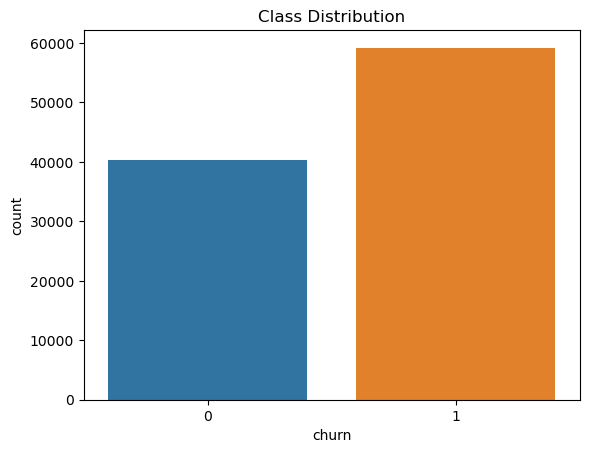

In [28]:
sns.countplot(x='churn', data=model_df)
plt.title('Class Distribution')
plt.show()

#### Target is balanced. 

#### Data Transformation

In [29]:
def state_encoding(state):
    if state in ['RS', 'SC', 'PR']:
        return 'southern'
    elif state in ['SP', 'RJ', 'MG', 'ES']:
        return 'southeastern'
    elif state in ['MT', 'MS', 'GO', 'DF']:
        return 'centralwestern'
    elif state in ['MA', 'PI', 'CE', 'RN', 'PB', 'PE', 'AL', 'SE', 'BA']:
        return 'northeastern'
    else: 
        return 'northern'

In [30]:
model_df['customer_state'] = model_df['customer_state'].apply(state_encoding)

#### Observation:
Since the states are spread across the brazil, we are grouping the states based on the regions they are in, 
namely southern, southeastern, centralwestern, northeastern and northern. 

In [31]:
model_df.head()

,customer_state,price,freight_value,payment_type,payment_installments,review_score,recency,frequency,monetary_value,customer_tenure,num_orders,churn
0,southeastern,124.99,21.88,credit_card,2,4,469,1,146.87,0,1,1
1,northern,112.99,24.90,credit_card,1,1,293,2,551.58,0,1,1
3,southern,124.99,15.62,credit_card,7,3,478,1,140.61,0,1,1
4,southeastern,106.99,30.59,credit_card,10,4,206,1,137.58,0,1,1
5,southern,126.99,15.06,credit_card,5,4,523,1,142.05,0,1,1


#### Observation:
Since the states are spread across the brazil, we are grouping the states based on the regions they are in, 
namely southern, southeastern, centralwestern, northeastern and northern. 

In [32]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99559 entries, 0 to 113759
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   customer_state        99559 non-null  object 
 1   price                 99559 non-null  float64
 2   freight_value         99559 non-null  float64
 3   payment_type          99559 non-null  object 
 4   payment_installments  99559 non-null  int64  
 5   review_score          99559 non-null  int64  
 6   recency               99559 non-null  int64  
 7   frequency             99559 non-null  int64  
 8   monetary_value        99559 non-null  float64
 9   customer_tenure       99559 non-null  int64  
 10  num_orders            99559 non-null  int64  
 11  churn                 99559 non-null  int64  
dtypes: float64(3), int64(7), object(2)
memory usage: 9.9+ MB


### Label encoding

#### feature transformation

In [33]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

# Apply label encoding for columns
for col in ['customer_state', 'payment_type']:
    model_df[col] = label_encoder.fit_transform(model_df[col])

In [34]:
# Pair Plots (Numeric)
#sns.pairplot(model_df, diag_kind='kde', hue='churn')

In [35]:
model_df.head(50)

,customer_state,price,freight_value,payment_type,payment_installments,review_score,recency,frequency,monetary_value,customer_tenure,num_orders,churn
0,3,124.99,21.88,1,2,4,469,1,146.87,0,1,1
1,2,112.99,24.90,1,1,1,293,2,551.58,0,1,1
3,4,124.99,15.62,1,7,3,478,1,140.61,0,1,1
4,3,106.99,30.59,1,10,4,206,1,137.58,0,1,1
5,4,126.99,15.06,1,5,4,523,1,142.05,0,1,1
6,3,124.99,30.71,0,1,4,470,1,155.70,0,1,1
7,0,126.99,21.34,1,2,2,528,1,148.33,0,1,1
8,3,116.99,33.08,1,3,3,167,1,150.07,0,1,0
9,3,106.99,21.76,0,1,2,215,2,515.00,0,1,1
11,4,124.99,15.62,1,6,4,477,6,5061.96,0,1,1


#### To determine the importance of features for predicting churn
This fits a Random Forest classifier on the data, extracts feature importances, and then displays them in a DataFrame. Features with higher importance values are considered more influential in predicting churn.

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X = model_df.drop('churn', axis=1)
y = model_df['churn']


In [37]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [38]:

# Initialize Random Forest classifier
rf_model = RandomForestClassifier(random_state=42)

# Fit the model
rf_model.fit(X_train, y_train)



RandomForestClassifier(random_state=42)

In [39]:
# Get feature importances
feature_importances = rf_model.feature_importances_

In [40]:
# Create a DataFrame to display feature importances
importances_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

In [41]:
# Sort features by importance
importances_df = importances_df.sort_values(by='Importance', ascending=False)

In [42]:
# Display the feature importances
print(importances_df)

                 Feature  Importance
6                recency    0.948256
2          freight_value    0.038757
8         monetary_value    0.003858
1                  price    0.003334
0         customer_state    0.002280
4   payment_installments    0.001100
7              frequency    0.000639
10            num_orders    0.000606
5           review_score    0.000453
9        customer_tenure    0.000367
3           payment_type    0.000349


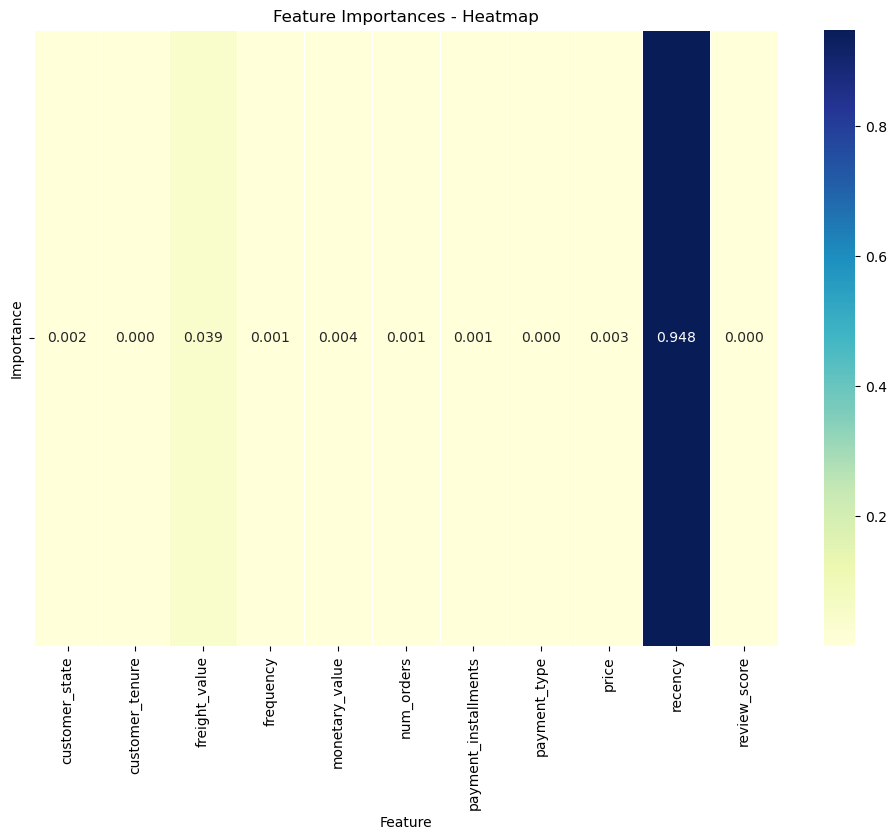

In [43]:
import seaborn as sns

# Increase figure size
plt.figure(figsize=(12, 8))

# Plotting a seaborn heatmap with numbers
sns.heatmap(importances_df.pivot_table(index='Feature', values='Importance').T,
            cmap="YlGnBu", annot=True, fmt=".3f", linewidths=.5)

plt.title('Feature Importances - Heatmap')
plt.show()



#### Importance of features: correlation:

In [44]:
correlation_matrix = model_df.corr()
correlation_with_churn = correlation_matrix['churn'].abs().sort_values(ascending=False)


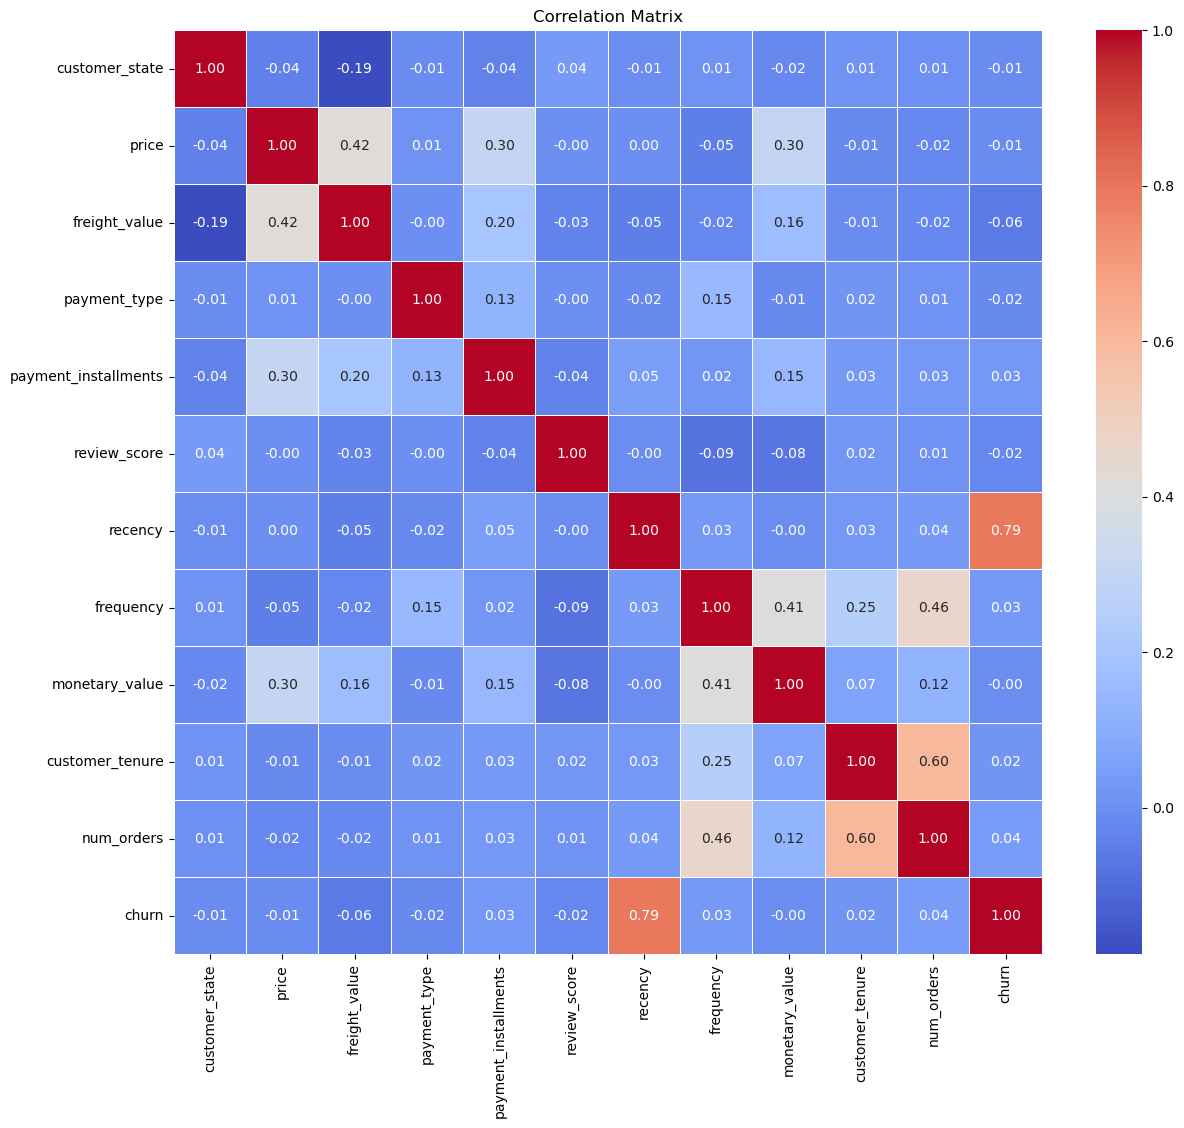

In [45]:
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()



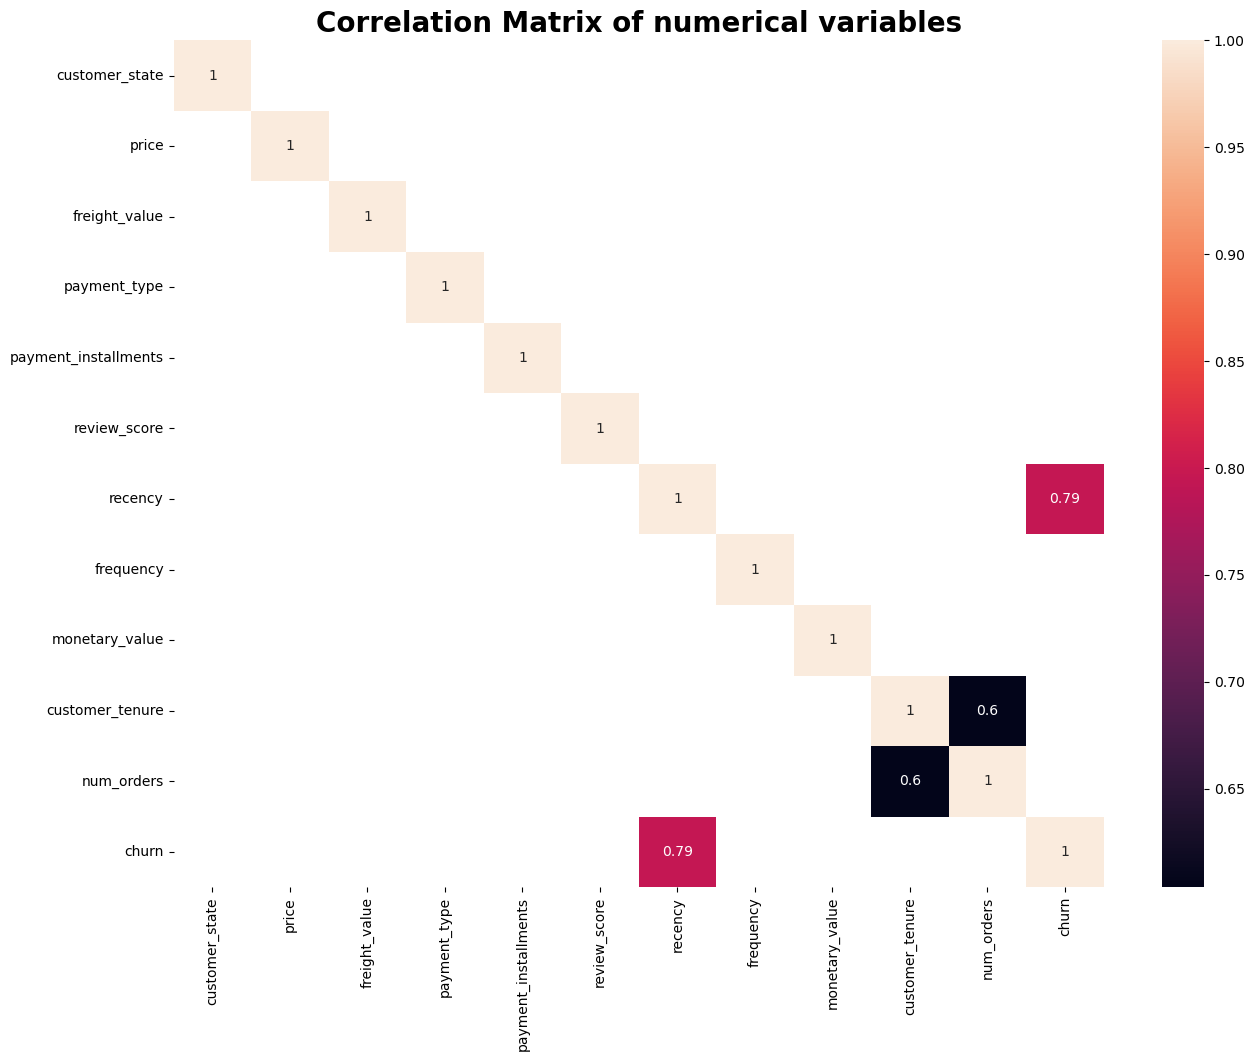

In [46]:
plt.figure(figsize=(15,11))
sns.heatmap(model_df.corr()[model_df.corr() > 0.5], annot = True)
plt.title('Correlation Matrix of numerical variables',fontsize=20,fontweight='bold')
plt.show()

In [47]:
#model_df = final[['recency','frequency','monetary_value','price','freight_value','review_score','churn']]
model_df.head()

,customer_state,price,freight_value,payment_type,payment_installments,review_score,recency,frequency,monetary_value,customer_tenure,num_orders,churn
0,3,124.99,21.88,1,2,4,469,1,146.87,0,1,1
1,2,112.99,24.90,1,1,1,293,2,551.58,0,1,1
3,4,124.99,15.62,1,7,3,478,1,140.61,0,1,1
4,3,106.99,30.59,1,10,4,206,1,137.58,0,1,1
5,4,126.99,15.06,1,5,4,523,1,142.05,0,1,1


#### Feature Transformation

In [48]:
from scipy.stats import skew, kurtosis

In [49]:
feature_trans = model_df.copy()
feature_normal = []
feature_not_normal = []

for i in feature_trans:
  skw = skew(model_df[i])
  kts = kurtosis(model_df[i])
  if skw < 2 and skw > -2:
    if kts < 2 and kts > -2:
      feature_normal.append(i)
    else:
      feature_not_normal.append(i)
  else:
    feature_not_normal.append(i)

print('Normal_distribution:', feature_normal)
print('Not_normal_distribution:', feature_not_normal)

Normal_distribution: ['customer_state', 'payment_installments', 'review_score', 'recency', 'churn']
Not_normal_distribution: ['price', 'freight_value', 'payment_type', 'frequency', 'monetary_value', 'customer_tenure', 'num_orders']


#### Model

In [50]:
#model_df['churn'] = final['churn'].astype(int)
#model_df['churn'] = model_df.churn.astype('int')

In [51]:
model_df['churn'].unique()

array([1, 0])

In [52]:
model_df.drop(columns = ['recency'], axis = 1, inplace = True)

In [53]:
model_df.head()

,customer_state,price,freight_value,payment_type,payment_installments,review_score,frequency,monetary_value,customer_tenure,num_orders,churn
0,3,124.99,21.88,1,2,4,1,146.87,0,1,1
1,2,112.99,24.90,1,1,1,2,551.58,0,1,1
3,4,124.99,15.62,1,7,3,1,140.61,0,1,1
4,3,106.99,30.59,1,10,4,1,137.58,0,1,1
5,4,126.99,15.06,1,5,4,1,142.05,0,1,1


#### Observation:
The Recency feature is dropped for the model building, as it is used to create the target variable. 
Predictions would be 100% accurate if the Recency feature is not dropped, which would be an ideal model

In [54]:
from sklearn.model_selection import train_test_split
X = model_df.drop(['churn'], axis=1)
y = model_df['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [55]:
# print dimension of train set
print('X_train', X_train.shape)
print('y_train', y_train.shape)

# print dimension of test set
print('X_test', X_test.shape)
print('y_test', y_test.shape)

X_train (79647, 10)
y_train (79647,)
X_test (19912, 10)
y_test (19912,)


Statistically proving train & test are good representations of overall data.


A t-test independence on each column to show both have equal or similar representation.

Null Hypothesis, H0: Both sets have same mean, thus they have equal representation.


Alternate Hypothesis, Ha: Both sets have unequal means, thus unequal representation.

In [56]:
tstats,pvals = stats.ttest_ind(X_train, X_test)
ref_df = pd.DataFrame(pvals,index=X_train.columns,columns=['pvals'])
(ref_df < 0.05).any()

pvals    False
dtype: bool

#### Observation:
As all the columns have p-values greater than significance level of 0.05, we do not reject the null hypothesis 
and we can conclude that all independent features are properly represented both in train and test sets.

### Decision Tree model¶

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# print dimension of train set
print('X_train', X_train.shape)
print('y_train', y_train.shape)

# print dimension of test set
print('X_test', X_test.shape)
print('y_test', y_test.shape)

X_train (79647, 10)
y_train (79647,)
X_test (19912, 10)
y_test (19912,)


In [58]:
tstats,pvals = stats.ttest_ind(X_train, X_test)
ref_df = pd.DataFrame(pvals,index=X_train.columns,columns=['pvals'])
(ref_df < 0.05).any()

pvals    False
dtype: bool

In [59]:
from sklearn.tree import DecisionTreeClassifier
decisionTree = DecisionTreeClassifier()
decisionTree = decisionTree.fit(X_train, y_train)

In [60]:
ypred_proba_dt = decisionTree.predict(X_test)

In [61]:
ypred_dt = [0 if i < 0.5 else 1 for i in ypred_proba_dt]
ypred_dt[:10]

[1, 1, 1, 0, 1, 1, 0, 0, 1, 1]

In [62]:
ypred_proba_dt_train = decisionTree.predict(X_train)
ypred_dt_train = [0 if i < 0.5 else 1 for i in ypred_proba_dt_train]

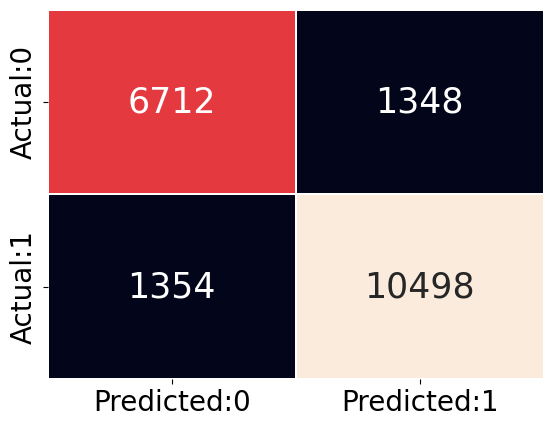

In [63]:
cm = confusion_matrix(y_test, ypred_dt)
conf_matrix = pd.DataFrame(data = cm,columns = ['Predicted:0','Predicted:1'], index = ['Actual:0','Actual:1'])
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cbar = False, 
            linewidths = 0.1, annot_kws = {'size':25})
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.show()

In [64]:
print(classification_report(y_test, ypred_dt))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83      8060
           1       0.89      0.89      0.89     11852

    accuracy                           0.86     19912
   macro avg       0.86      0.86      0.86     19912
weighted avg       0.86      0.86      0.86     19912



#### Decision Tree Accuracy: 0.87

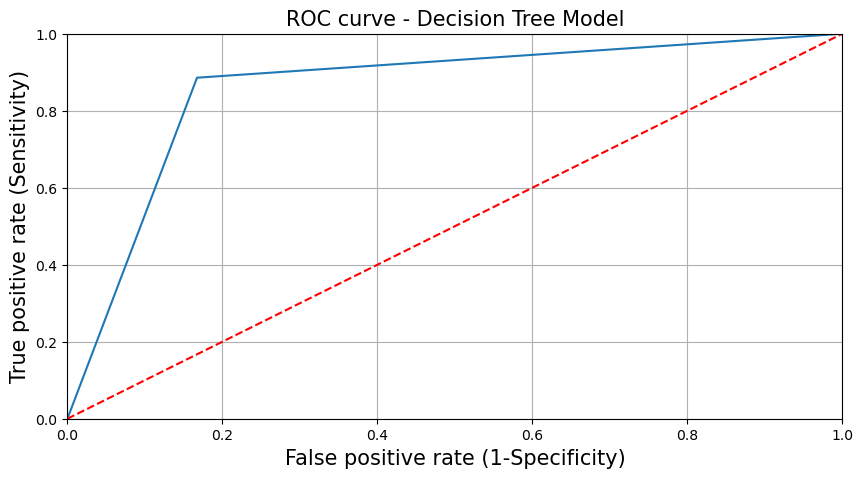

In [65]:
plt.figure(figsize = (10, 5))
fpr, tpr, thresholds = roc_curve(y_test, ypred_proba_dt)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot([0, 1], [0, 1],'r--')
plt.title('ROC curve - Decision Tree Model', fontsize = 15)
plt.xlabel('False positive rate (1-Specificity)', fontsize = 15)
plt.ylabel('True positive rate (Sensitivity)', fontsize = 15)
plt.grid(True)

###  XG Boost Model¶

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# print dimension of train set
print('X_train', X_train.shape)
print('y_train', y_train.shape)

# print dimension of test set
print('X_test', X_test.shape)
print('y_test', y_test.shape)

X_train (79647, 10)
y_train (79647,)
X_test (19912, 10)
y_test (19912,)


In [67]:
tstats,pvals = stats.ttest_ind(X_train, X_test)
ref_df = pd.DataFrame(pvals,index=X_train.columns,columns=['pvals'])
(ref_df < 0.05).any()

pvals    False
dtype: bool

In [68]:
from xgboost import XGBClassifier
xgBoost = XGBClassifier()
xbBoost = xgBoost.fit(X_train, y_train)

In [69]:
ypred_proba_xg = xgBoost.predict(X_test)

In [70]:
ypred_xg = [0 if i < 0.5 else 1 for i in ypred_proba_xg]
ypred_xg[:10]

[1, 1, 1, 0, 1, 0, 0, 1, 1, 1]

In [71]:
ypred_proba_xg_train = xgBoost.predict(X_train)
ypred_xg_train = [0 if i < 0.5 else 1 for i in ypred_proba_xg_train]

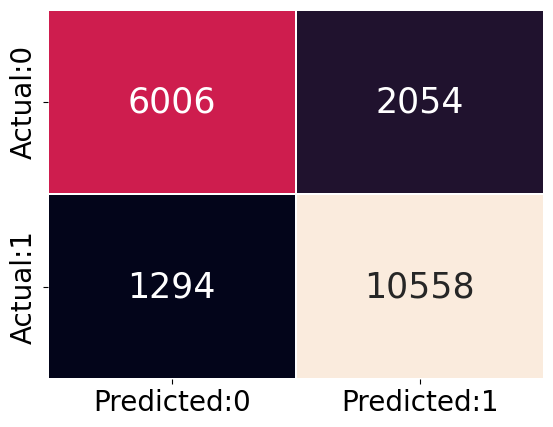

In [75]:
cm = confusion_matrix(y_test, ypred_xg)
conf_matrix = pd.DataFrame(data = cm,columns = ['Predicted:0','Predicted:1'], index = ['Actual:0','Actual:1'])
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cbar = False, 
            linewidths = 0.1, annot_kws = {'size':25})
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.show()


In [73]:
print(classification_report(y_test, ypred_xg))

              precision    recall  f1-score   support

           0       0.82      0.75      0.78      8060
           1       0.84      0.89      0.86     11852

    accuracy                           0.83     19912
   macro avg       0.83      0.82      0.82     19912
weighted avg       0.83      0.83      0.83     19912



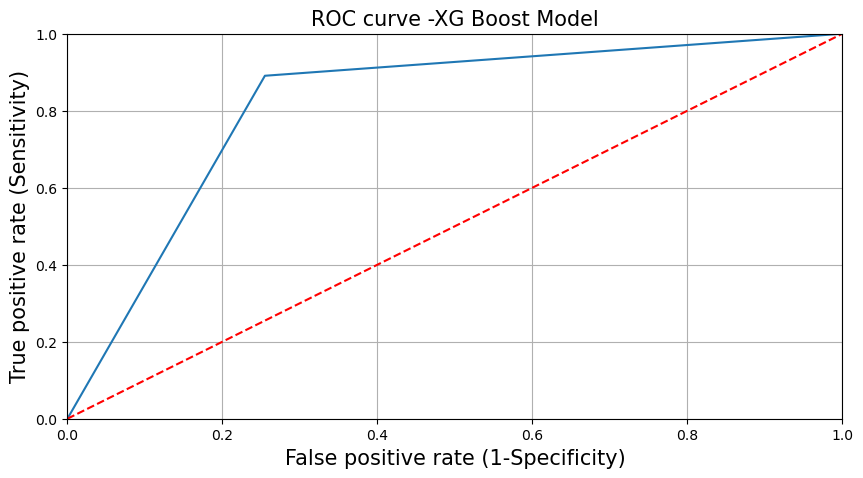

In [74]:
plt.figure(figsize = (10, 5))
fpr, tpr, thresholds = roc_curve(y_test, ypred_proba_xg)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot([0, 1], [0, 1],'r--')
plt.title('ROC curve -XG Boost Model', fontsize = 15)
plt.xlabel('False positive rate (1-Specificity)', fontsize = 15)
plt.ylabel('True positive rate (Sensitivity)', fontsize = 15)
plt.grid(True)

### Random Forest Classifier¶

In [167]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 500)
print('xtrain: ', X_train.shape)
print('ytrain: ', y_train.shape)
print('xtest: ', X_test.shape)
print('ytest: ', y_test.shape)

xtrain:  (79647, 10)
ytrain:  (79647,)
xtest:  (19912, 10)
ytest:  (19912,)


In [168]:
tstats,pvals = stats.ttest_ind(X_train, X_test)
ref_df = pd.DataFrame(pvals,index=X_train.columns,columns=['pvals'])
(ref_df < 0.05).any()

pvals    True
dtype: bool

In [169]:
rand = RandomForestClassifier()
rand_model = rand.fit(X_train,y_train)

In [170]:
ypred_proba_random = rand_model.predict(X_test)

In [171]:
ypred_random = [0 if i < 0.5 else 1 for i in ypred_proba_random]
ypred_random[:10]

[1, 0, 1, 1, 0, 0, 1, 1, 1, 1]

In [172]:
ypred_proba_random_train = rand_model.predict(X_train)
ypred_random_train = [0 if i < 0.5 else 1 for i in ypred_proba_random_train]

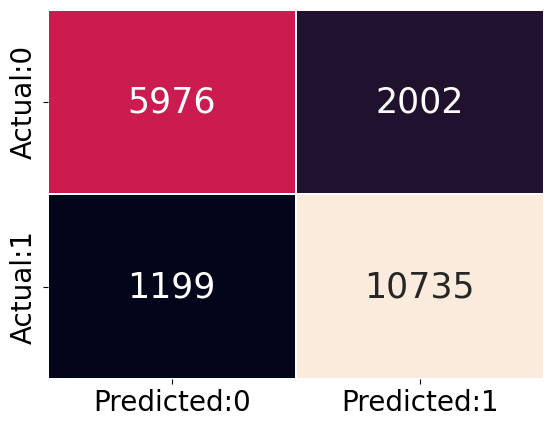

In [173]:
cm = confusion_matrix(y_test, ypred_random)
conf_matrix = pd.DataFrame(data = cm,columns = ['Predicted:0','Predicted:1'], index = ['Actual:0','Actual:1'])
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cbar = False, 
            linewidths = 0.1, annot_kws = {'size':25})
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.show()

In [174]:
print(classification_report(y_test, ypred_random))

              precision    recall  f1-score   support

           0       0.83      0.75      0.79      7978
           1       0.84      0.90      0.87     11934

    accuracy                           0.84     19912
   macro avg       0.84      0.82      0.83     19912
weighted avg       0.84      0.84      0.84     19912



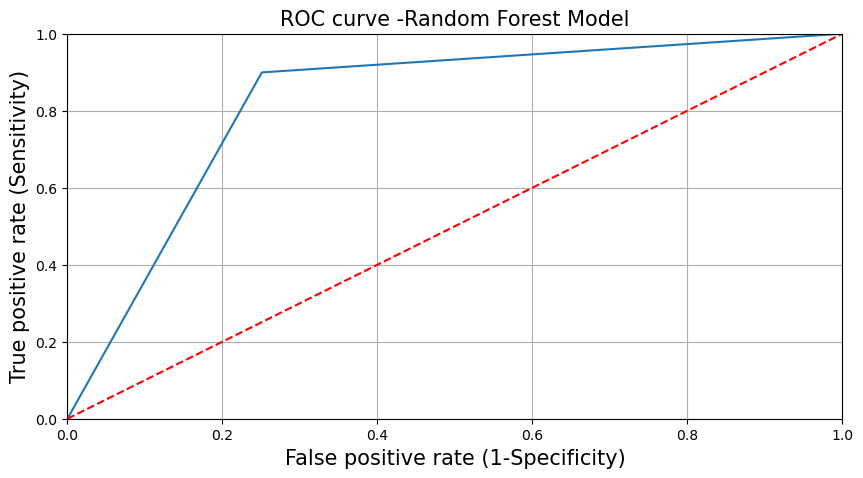

In [175]:
plt.figure(figsize = (10, 5))
fpr, tpr, thresholds = roc_curve(y_test, ypred_proba_random)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot([0, 1], [0, 1],'r--')
plt.title('ROC curve -Random Forest Model', fontsize = 15)
plt.xlabel('False positive rate (1-Specificity)', fontsize = 15)
plt.ylabel('True positive rate (Sensitivity)', fontsize = 15)
plt.grid(True)

### Logistic Regression

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 500)
print('xtrain: ', X_train.shape)
print('ytrain: ', y_train.shape)
print('xtest: ', X_test.shape)
print('ytest: ', y_test.shape)

xtrain:  (79647, 10)
ytrain:  (79647,)
xtest:  (19912, 10)
ytest:  (19912,)


In [77]:
tstats,pvals = stats.ttest_ind(X_train, X_test)
ref_df = pd.DataFrame(pvals,index=X_train.columns,columns=['pvals'])
(ref_df < 0.05).any()

pvals    True
dtype: bool

In [78]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr_model = lr.fit(X_train,y_train)

In [79]:
ypred_proba_log = lr_model.predict(X_test)
ypred_log = [0 if i < 0.5 else 1 for i in ypred_proba_log]
ypred_log[:10]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [80]:
ypred_proba_log_train = lr_model.predict(X_train)
ypred_log_train = [0 if i < 0.5 else 1 for i in ypred_proba_log_train]

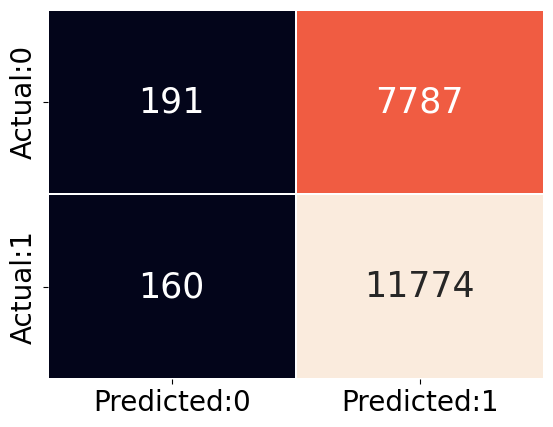

In [81]:
cm = confusion_matrix(y_test, ypred_log)
conf_matrix = pd.DataFrame(data = cm,columns = ['Predicted:0','Predicted:1'], index = ['Actual:0','Actual:1'])
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cbar = False, 
            linewidths = 0.1, annot_kws = {'size':25})
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.show()

In [82]:
print(classification_report(y_test, ypred_log))



              precision    recall  f1-score   support

           0       0.54      0.02      0.05      7978
           1       0.60      0.99      0.75     11934

    accuracy                           0.60     19912
   macro avg       0.57      0.51      0.40     19912
weighted avg       0.58      0.60      0.47     19912



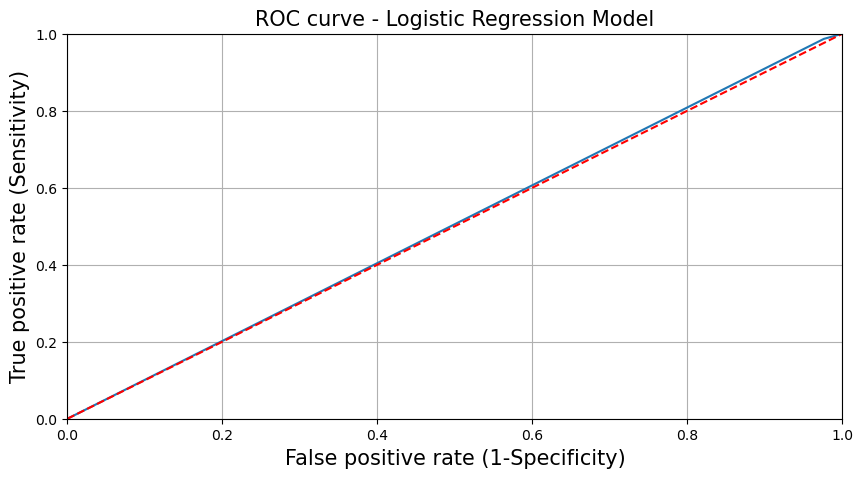

In [83]:
plt.figure(figsize = (10, 5))
fpr, tpr, thresholds = roc_curve(y_test, ypred_proba_log)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot([0, 1], [0, 1],'r--')
plt.title('ROC curve - Logistic Regression Model', fontsize = 15)
plt.xlabel('False positive rate (1-Specificity)', fontsize = 15)
plt.ylabel('True positive rate (Sensitivity)', fontsize = 15)
plt.grid(True)


### Observation:
1. Logistic Regression:

    Accuracy: 60%
    Precision (churn=1): 60%
    Recall (churn=1): 99%
    F1-score (churn=1): 75%

Insights:

    Low precision for churn=1 suggests that there are false positives.
    High recall for churn=1 indicates the model is good at capturing actual churn cases.

2. Decision Tree model:

    Accuracy: 87%
    Precision (churn=1): 89%
    Recall (churn=1): 89%
    F1-score (churn=1): 89%

Insights:

    Balanced precision and recall for churn=1.
    Good overall performance.

3. XGBoost:

    Accuracy: 83%
    Precision (churn=1): 84%
    Recall (churn=1): 89%
    F1-score (churn=1): 86%

Insights:

    Good precision and recall for churn=1.
    Overall high performance.

4. Random Forest:

    Accuracy: 84%
    Precision (churn=1): 84%
    Recall (churn=1): 97%
    F1-score (churn=1): 87%

Insights:

    Similar performance to XGBoost, with high precision and recall for churn=1.
    
    

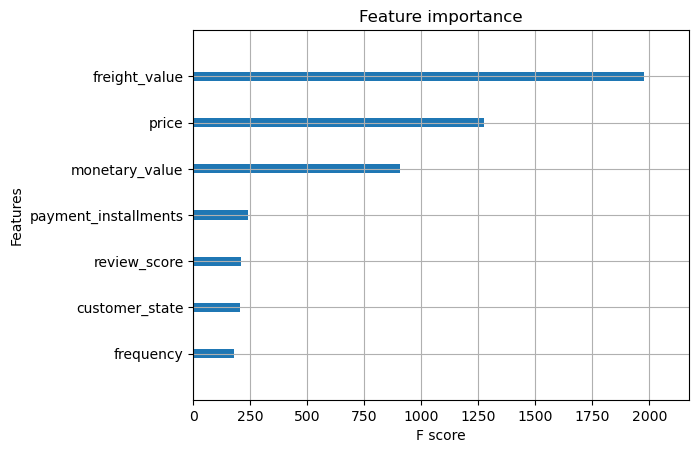

Top 7 important features: ['freight_value', 'price', 'monetary_value', 'payment_installments', 'review_score', 'customer_state', 'frequency']


In [97]:
from xgboost import XGBClassifier, plot_importance
import matplotlib.pyplot as plt

# Assuming xgBoost is your trained XGBoost model
xgBoost = XGBClassifier()
xgBoost.fit(X_train, y_train)

# Plot feature importance
plot_importance(xgBoost, importance_type='weight', show_values=False)
plt.show()

# Extract the top N important features
top_n = 7  # Specify the number of top features you want to consider
important_features_xgboost = xgBoost.get_booster().get_score(importance_type='weight')
important_features_xgboost = sorted(important_features_xgboost.items(), key=lambda x: x[1], reverse=True)[:top_n]
important_features_xgboost = [feature[0] for feature in important_features_xgboost]

print("Top", top_n, "important features:", important_features_xgboost)


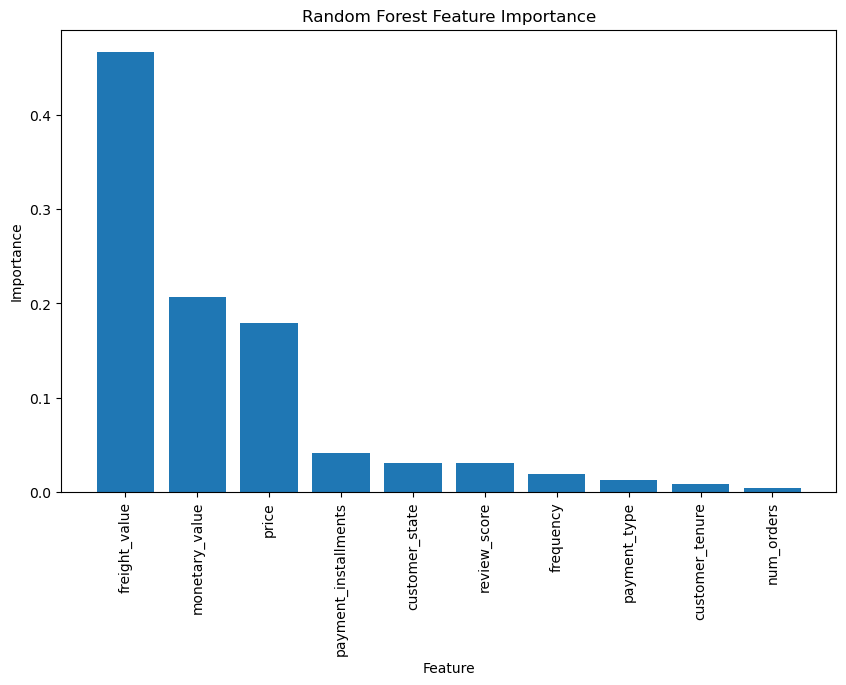

Top 7 important features: ['freight_value', 'monetary_value', 'price', 'payment_installments', 'customer_state', 'review_score', 'frequency']


In [85]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# Assuming rand is your trained RandomForestClassifier model
rand = RandomForestClassifier()
rand_model = rand.fit(X_train, y_train)

# Plot feature importance
feature_importance = rand_model.feature_importances_
features = X_train.columns

# Sort feature importance in descending order
sorted_idx = feature_importance.argsort()[::-1]

# Specify the number of top features you want to consider (e.g., top 10)
top_n = 7

# Get the top N important features
important_features = [features[i] for i in sorted_idx[:top_n]]

# Plot the top features
plt.figure(figsize=(10, 6))
plt.bar(range(len(features)), feature_importance[sorted_idx], align="center")
plt.xticks(range(len(features)), [features[i] for i in sorted_idx], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Random Forest Feature Importance")
plt.show()

print("Top", top_n, "important features:", important_features)



### Hypermeter tuning

#### XG boost

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X[important_features_xgboost], y, test_size=0.2, random_state=42)
# print dimension of train set
print('X_train', X_train.shape)
print('y_train', y_train.shape)

# print dimension of test set
print('X_test', X_test.shape)
print('y_test', y_test.shape)

X_train (79647, 7)
y_train (79647,)
X_test (19912, 7)
y_test (19912,)


In [87]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Define the XGBoost model
xgBoost = XGBClassifier(random_state = 10)

In [88]:
# Define hyperparameter grid for fine-tuning
parameters = [
    {'n_estimators': [30, 40, 50, 70, 90],
     'max_depth': range(2, 7),
     'learning_rate': [0.1, 0.2, 0.4, 0.5]}]


In [89]:
# Create a GridSearchCV object for XGBoost
gcv_xgb = GridSearchCV(estimator=xgBoost, param_grid=parameters, cv=5)
gcv_xgb.fit(X_train, y_train)
            
# Print the best parameters
print("Best Parameters for XGBoost:", gcv_xgb.best_params_)

Best Parameters for XGBoost: {'learning_rate': 0.5, 'max_depth': 6, 'n_estimators': 90}


In [90]:
# Initialize XGBoost classifier with best parameters
xgBoost = XGBClassifier(learning_rate=0.5, max_depth=8, n_estimators=90,booster='gbtree')
xgBoost.fit(X_train, y_train)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=90, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [91]:
# Predictions on the test set
ypred_proba_xg = xgBoost.predict(X_test)
ypred_xg = [0 if i < 0.5 else 1 for i in ypred_proba_xg]
ypred_xg[:10]

[1, 1, 1, 0, 1, 0, 0, 1, 1, 1]

In [92]:
# Predictions on the training set
ypred_proba_xg_train = xgBoost.predict(X_train)
ypred_xg_train = [0 if i < 0.5 else 1 for i in ypred_proba_xg_train]


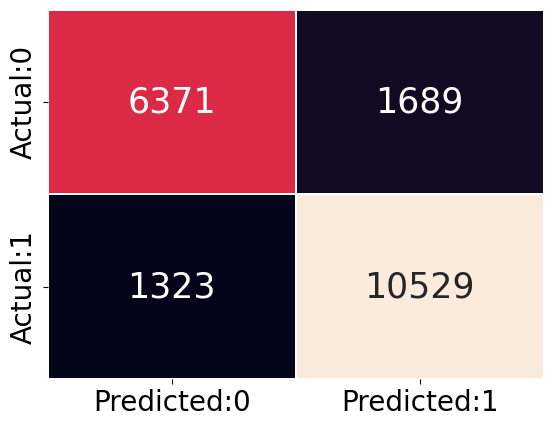

In [93]:
# Confusion Matrix
cm = confusion_matrix(y_test, ypred_xg)
conf_matrix = pd.DataFrame(data=cm, columns=['Predicted:0', 'Predicted:1'], index=['Actual:0', 'Actual:1'])
sns.heatmap(conf_matrix, annot=True, fmt='d', cbar=False, linewidths=0.1, annot_kws={'size': 25})
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

In [94]:
# Classification Report
print(classification_report(y_test, ypred_xg))

              precision    recall  f1-score   support

           0       0.83      0.79      0.81      8060
           1       0.86      0.89      0.87     11852

    accuracy                           0.85     19912
   macro avg       0.84      0.84      0.84     19912
weighted avg       0.85      0.85      0.85     19912



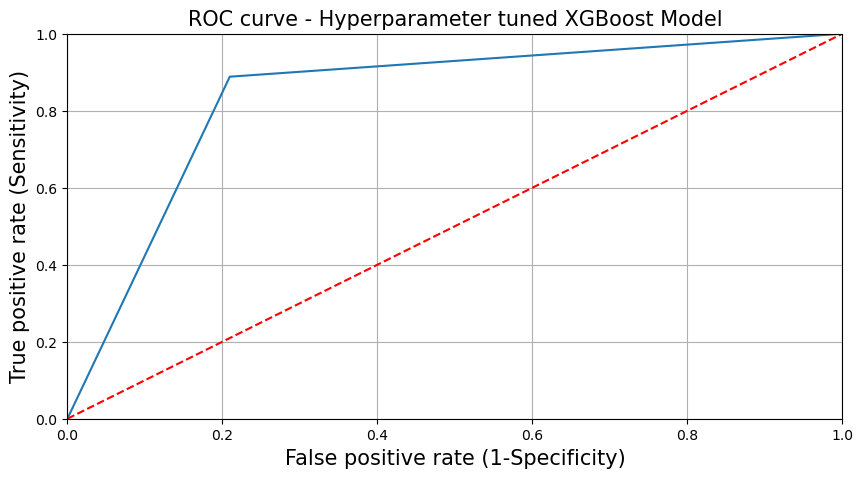

In [95]:
# ROC Curve
plt.figure(figsize=(10, 5))
fpr, tpr, thresholds = roc_curve(y_test, ypred_proba_xg)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot([0, 1], [0, 1], 'r--')
plt.title('ROC curve - Hyperparameter tuned XGBoost Model', fontsize=15)
plt.xlabel('False positive rate (1-Specificity)', fontsize=15)
plt.ylabel('True positive rate (Sensitivity)', fontsize=15)
plt.grid(True)
plt.show()

### Random Forest

In [198]:
X_train, X_test, y_train, y_test = train_test_split(X[important_features], y, test_size=0.2, random_state=500)

print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print('X_test: ', X_test.shape)
print('y_test: ', y_test.shape)


X_train:  (79647, 10)
y_train:  (79647,)
X_test:  (19912, 10)
y_test:  (19912,)


In [199]:
# Initialize RandomForest classifier
rand = RandomForestClassifier(random_state=10)

# Define hyperparameter grid for fine-tuning
parameters = [
    {'criterion': ['gini', 'entropy'],
     'max_features': ['sqrt', 'log2'],
     'max_depth': range(2, 7),
     'min_samples_split': range(2, 7),
     'max_leaf_nodes': range(2, 10)}
]

In [200]:
# Create a GridSearchCV object for RandomForest
gcv_rf = GridSearchCV(estimator=rand, param_grid=parameters, cv=5,n_jobs=8)
gcv_rf.fit(X_train, y_train)

# Print the best parameters
print("Best Parameters for Random Forest:", gcv_rf.best_params_)

Best Parameters for Random Forest: {'criterion': 'gini', 'max_depth': 6, 'max_features': 'sqrt', 'max_leaf_nodes': 9, 'min_samples_split': 2}


In [201]:
# Initialize RandomForest classifier with best parameters
rand = RandomForestClassifier(criterion='entropy', max_depth=6, max_features='sqrt', max_leaf_nodes=9, min_samples_split=2)
rand_model = rand.fit(X_train, y_train)


In [202]:
# Predictions on the test set
ypred_proba_random = rand_model.predict(X_test)
ypred_random = [0 if i < 0.5 else 1 for i in ypred_proba_random]
ypred_random[:10]

[1, 0, 1, 1, 1, 1, 1, 1, 1, 1]

In [203]:
# Predictions on the training set
ypred_proba_random_train = rand_model.predict(X_train)
ypred_random_train = [0 if i < 0.5 else 1 for i in ypred_proba_random_train]

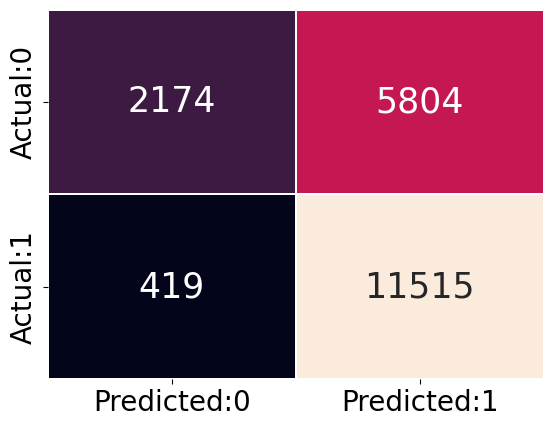

In [204]:
# Confusion Matrix
cm = confusion_matrix(y_test, ypred_random)
conf_matrix = pd.DataFrame(data=cm, columns=['Predicted:0', 'Predicted:1'], index=['Actual:0', 'Actual:1'])
sns.heatmap(conf_matrix, annot=True, fmt='d', cbar=False, linewidths=0.1, annot_kws={'size': 25})
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

In [205]:

# Classification Report
print(classification_report(y_test, ypred_random))

              precision    recall  f1-score   support

           0       0.84      0.27      0.41      7978
           1       0.66      0.96      0.79     11934

    accuracy                           0.69     19912
   macro avg       0.75      0.62      0.60     19912
weighted avg       0.73      0.69      0.64     19912



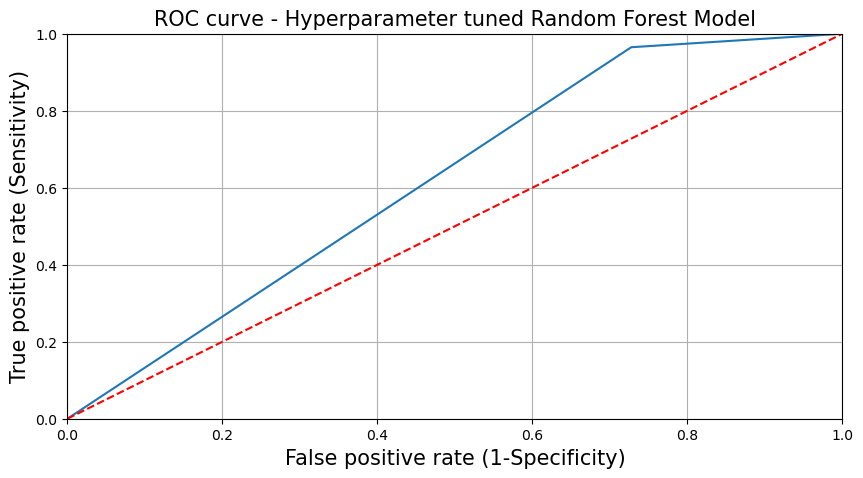

In [206]:
# ROC Curve
plt.figure(figsize=(10, 5))
fpr, tpr, thresholds = roc_curve(y_test, ypred_proba_random)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot([0, 1], [0, 1], 'r--')
plt.title('ROC curve - Hyperparameter tuned Random Forest Model', fontsize=15)
plt.xlabel('False positive rate (1-Specificity)', fontsize=15)
plt.ylabel('True positive rate (Sensitivity)', fontsize=15)
plt.grid(True)
plt.show()

### Decision Tree

In [98]:
from sklearn.model_selection import GridSearchCV
X_train, X_test, y_train, y_test = train_test_split(X[important_features_xgboost], y, test_size=0.2, random_state=500)

print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print('X_test: ', X_test.shape)
print('y_test: ', y_test.shape)


X_train:  (79647, 7)
y_train:  (79647,)
X_test:  (19912, 7)
y_test:  (19912,)


In [99]:
# Define the Decision Tree Classifier
decisionTree = DecisionTreeClassifier(random_state=42)

# Define the hyperparameters and their possible values
param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


# Create GridSearchCV
grid_search = GridSearchCV(decisionTree, param_grid, cv=5, scoring='accuracy', n_jobs=5)

In [100]:
# Fit the model to the data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

Best Hyperparameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}


In [101]:

# Use the best model for predictions
best_decisionTree = grid_search.best_estimator_
ypred_proba_dt_tuned = best_decisionTree.predict(X_test)
ypred_dt_tuned = [0 if i < 0.5 else 1 for i in ypred_proba_dt_tuned]



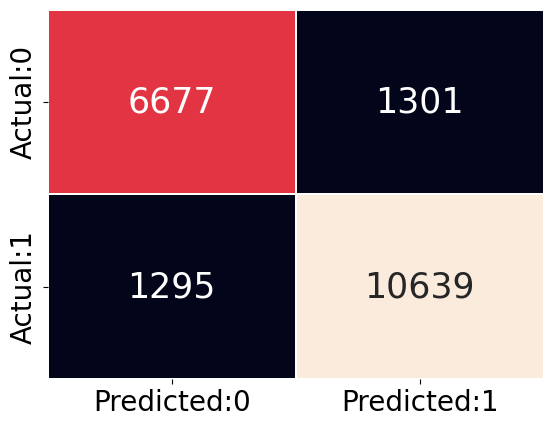

In [102]:
# Print confusion matrix and heatmap
cm_tuned = confusion_matrix(y_test, ypred_dt_tuned)
conf_matrix_tuned = pd.DataFrame(data=cm_tuned, columns=['Predicted:0', 'Predicted:1'], index=['Actual:0', 'Actual:1'])
sns.heatmap(conf_matrix_tuned, annot=True, fmt='d', cbar=False, linewidths=0.1, annot_kws={'size': 25})
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

In [103]:
# Classification Report
print(classification_report(y_test, ypred_dt_tuned))

              precision    recall  f1-score   support

           0       0.84      0.84      0.84      7978
           1       0.89      0.89      0.89     11934

    accuracy                           0.87     19912
   macro avg       0.86      0.86      0.86     19912
weighted avg       0.87      0.87      0.87     19912



In [104]:
from joblib import dump

# Save the trained model to a .joblib file
file_path = 'decisionTree.joblib'
dump(grid_search, file_path)


['decisionTree.joblib']

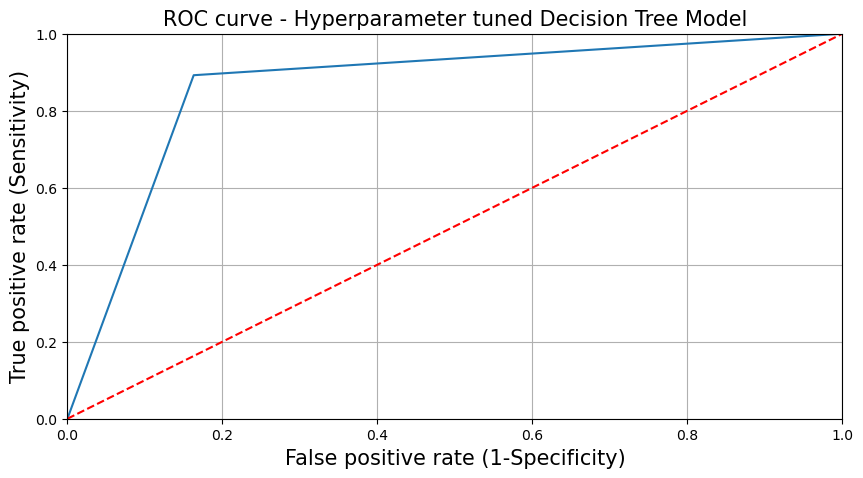

In [220]:
# ROC Curve
plt.figure(figsize=(10, 5))
fpr, tpr, thresholds = roc_curve(y_test, ypred_dt_tuned)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot([0, 1], [0, 1], 'r--')
plt.title('ROC curve - Hyperparameter tuned Decision Tree Model', fontsize=15)
plt.xlabel('False positive rate (1-Specificity)', fontsize=15)
plt.ylabel('True positive rate (Sensitivity)', fontsize=15)
plt.grid(True)
plt.show()

### Model Interpretation

### Decision Tree is best performing model